# Week 4C: Train Keypoints Classifier, i.e. Pose Classifier

In this notebook we are going to train our own pose classifier in PyTorch based on the dataset we built from the python script and notebook `00` and `01` respectively.

**Before you go any further** make sure you have already created and saved your csv file in `class-datasets/my-pose-classification-dataset`.

Code adapted from this [repo](https://github.com/Alimustoofaa/YoloV8-Pose-Keypoint-Classification/tree/master).

### Setting up your Python environment

Before you work through this notebook, please follow the instructions in [Setup-and-test-conda-environment.ipynb](Setup-and-test-conda-environment.ipynb)

Once you have done that you will need to make sure that the environment selected to run this notebook and all the other notebooks used in this unit is called `aim`. 

To do this click the **Select kernel** button in the top right corner of this notebook, and then select `aim`.

To make sure that is configured properly, Hit the run cell button (▶) on the cell below:

In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

aim


Does it output the text `aim`?

If it does not output the text `aim`, please revisit and follow the instructions in [Setup-and-test-conda-environment.ipynb](Setup-and-test-conda-environment.ipynb).

If you still cannot get it working, please raise this with the course instructor. 

Now you can import the libraries you need to train the classifier:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

##### Hyperparameters

Now let's define our hyperparameters:

In [3]:
device = 'cpu'
num_epochs = 200
num_classes = 3
num_keypoints = 34
test_size = 0.3
batch_size = 128
learn_rate = 0.001
data_path = 'class-datasets/my-pose-classification-dataset/poses_keypoints.csv'

##### Read Dataset

Here, we are reading the first 5 rows of our dataset.

In [4]:
df = pd.read_csv(data_path)
df = df.drop('image_name', axis=1)
df.head()

,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0.499424,0.472427,0.542937,0.396961,0.462468,0.394208,0.600961,0.447014,0.414560,...,0.420865,0.971498,0.637712,0.779919,0.348256,0.742999,0.469817,0.830270,0.370147,0.804596
1,0,0.498795,0.472976,0.542529,0.397311,0.462499,0.393901,0.600813,0.446435,0.415404,...,0.422637,0.972520,0.636484,0.779905,0.347277,0.740608,0.467278,0.828791,0.366472,0.804371
2,0,0.500610,0.470773,0.544500,0.395134,0.463958,0.392337,0.602997,0.447188,0.416738,...,0.423064,0.971096,0.635627,0.779955,0.348611,0.741551,0.468780,0.831774,0.367555,0.805178
3,0,0.500440,0.470546,0.544361,0.395156,0.463843,0.392402,0.603066,0.446797,0.416689,...,0.422922,0.970828,0.635743,0.780208,0.348308,0.741928,0.468822,0.830511,0.367587,0.803960
4,0,0.498601,0.472903,0.542461,0.397401,0.462215,0.394062,0.601006,0.446900,0.415052,...,0.421990,0.972351,0.637010,0.779713,0.347286,0.741038,0.468818,0.828317,0.367778,0.804074


##### Count and plot our data per class

In the following two cells, we are counting and plotting the number of data per class.

In [5]:
df.label.value_counts()

label
0    100
1    100
2    100
Name: count, dtype: int64

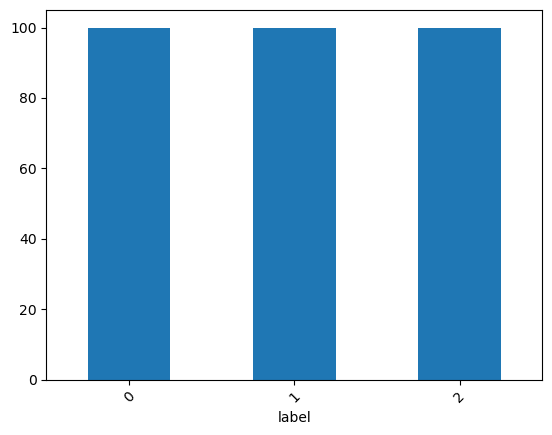

In [6]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

##### Define the 1st column as our labels `y` and the following 34 columns as our keypoints input dataset `X`

In [7]:
# Use the encoder label, to turn each label into an index number
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
# Get keypoint dataset 
X = df.iloc[:, 1:] # start from 11: if you want to skip the keypoints of the face
X

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.499424,0.472427,0.542937,0.396961,0.462468,0.394208,0.600961,0.447014,0.414560,0.438943,...,0.420865,0.971498,0.637712,0.779919,0.348256,0.742999,0.469817,0.830270,0.370147,0.804596
1,0.498795,0.472976,0.542529,0.397311,0.462499,0.393901,0.600813,0.446435,0.415404,0.436754,...,0.422637,0.972520,0.636484,0.779905,0.347277,0.740608,0.467278,0.828791,0.366472,0.804371
2,0.500610,0.470773,0.544500,0.395134,0.463958,0.392337,0.602997,0.447188,0.416738,0.438613,...,0.423064,0.971096,0.635627,0.779955,0.348611,0.741551,0.468780,0.831774,0.367555,0.805178
3,0.500440,0.470546,0.544361,0.395156,0.463843,0.392402,0.603066,0.446797,0.416689,0.438246,...,0.422922,0.970828,0.635743,0.780208,0.348308,0.741928,0.468822,0.830511,0.367587,0.803960
4,0.498601,0.472903,0.542461,0.397401,0.462215,0.394062,0.601006,0.446900,0.415052,0.437313,...,0.421990,0.972351,0.637010,0.779713,0.347286,0.741038,0.468818,0.828317,0.367778,0.804074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.530053,0.447571,0.580328,0.349807,0.486277,0.346923,0.647700,0.391215,0.431928,0.382639,...,0.442110,0.949707,0.706950,0.770490,0.360740,0.754790,0.509543,0.831321,0.346198,0.830088
296,0.529346,0.444730,0.579351,0.346687,0.484978,0.345402,0.646707,0.391734,0.430752,0.386405,...,0.436902,0.949255,0.705933,0.767374,0.360824,0.753773,0.513987,0.835558,0.347577,0.829428
297,0.532382,0.449616,0.582616,0.351237,0.488464,0.348248,0.649407,0.393556,0.433947,0.384999,...,0.446877,0.945940,0.706990,0.768983,0.363351,0.753620,0.506419,0.834152,0.345452,0.833148
298,0.529743,0.449594,0.578762,0.351140,0.483107,0.352301,0.646054,0.389741,0.426436,0.389879,...,0.423867,0.959085,0.715387,0.770256,0.356308,0.748402,0.526075,0.845632,0.343936,0.818805


##### Train Test Split

Perform a train-test split with test_size=0.3 (defined in our hyperparameters), and a random but deterministic split and a strification.

Stratified sampling is a method of sampling that involves dividing a population into homogeneous subgroups known as strata, and then sampling from each stratum.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  210
Number of Testing keypoints:  90


In [10]:
# A glimpse into the test data in a table format
X_test

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
87,0.505729,0.483961,0.547438,0.394484,0.462140,0.397226,0.606488,0.434970,0.413070,0.439332,...,0.421598,1.000000,0.685241,0.853109,0.406516,0.812157,0.491106,1.000000,0.374887,0.942132
74,0.498732,0.472454,0.542475,0.396724,0.462025,0.393792,0.600960,0.446511,0.414544,0.437819,...,0.420801,0.972585,0.637750,0.780656,0.346489,0.742641,0.471636,0.830308,0.367035,0.804617
255,0.530830,0.451463,0.580496,0.352944,0.486543,0.351609,0.648124,0.388280,0.431912,0.383220,...,0.434923,0.951570,0.712758,0.770289,0.358103,0.759930,0.515917,0.833785,0.350567,0.831834
161,0.546091,0.441423,0.597948,0.345290,0.500400,0.331621,0.658316,0.395129,0.436013,0.364945,...,0.448468,0.951467,0.715325,0.765587,0.373835,0.736263,0.509926,0.805481,0.328896,0.816073
48,0.505216,0.479279,0.550264,0.396656,0.466825,0.396689,0.611543,0.443349,0.420206,0.440988,...,0.442564,0.991510,0.664924,0.808681,0.378700,0.763032,0.498506,0.865336,0.356303,0.826553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.504971,0.483918,0.546227,0.393411,0.460408,0.397705,0.605566,0.435423,0.410930,0.442713,...,0.407682,1.000000,0.695291,0.854869,0.403983,0.805921,0.504749,1.000000,0.370937,0.929369
216,0.530535,0.444895,0.579198,0.352614,0.486796,0.352617,0.647726,0.389928,0.431382,0.387061,...,0.430962,0.947978,0.724436,0.772911,0.349969,0.747048,0.546932,0.822027,0.393516,0.795466
134,0.542278,0.444321,0.593692,0.346602,0.496613,0.334727,0.654511,0.396446,0.433901,0.370146,...,0.451747,0.958332,0.715081,0.766696,0.370763,0.734233,0.510390,0.812888,0.316858,0.816693
272,0.528552,0.443470,0.578005,0.348338,0.485414,0.346627,0.645580,0.392567,0.430896,0.386121,...,0.435597,0.934857,0.721436,0.768706,0.349965,0.740697,0.538470,0.828597,0.385504,0.807312


##### MinMax scaling to scale each feature into a given range

For more information, look [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [11]:
# A glipse into the test data in the format of an array and after performing a minmax scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.21213236, 1.01065115, 0.14812207, ..., 1.06228131, 0.32155963,
        0.83045733],
       [0.08023392, 0.76122616, 0.06739591, ..., 0.15311016, 0.28198868,
        0.01368936],
       [0.68527563, 0.30622584, 0.68585889, ..., 0.1717367 , 0.19899773,
        0.17534414],
       ...,
       [0.90107292, 0.15140637, 0.90052841, ..., 0.05977703, 0.02911876,
        0.08541446],
       [0.64233434, 0.13295923, 0.64534177, ..., 0.14393973, 0.37506206,
        0.0296978 ],
       [0.07342771, 0.86640067, 0.05620328, ..., 0.18614377, 0.27792308,
        0.02364366]], shape=(90, 34))

##### Data Loader

The data are currently numpy arrays and need to get transformed into torch tensors in order to get into the dataloaders.

In [12]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [13]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

##### Define our simple feed forward network

In [15]:
class PoseClassificationMLP(nn.Module):
    def __init__(self):
      super(PoseClassificationMLP, self).__init__()
      self.fc1 = nn.Linear(num_keypoints, 256)
      self.fc2 = nn.Linear(256, num_classes)     
  
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

##### Setup core objects

Here we setup our core objects, the model, the loss function and the optimiser.

In [16]:
model = PoseClassificationMLP()
model.to(device)

# Cross entropy loss for training classification
criterion = nn.CrossEntropyLoss()

# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

##### Training loop

Here is our training loop for our data.

In [17]:
train_losses = []
best_loss = 100000
for epoch in range(num_epochs):
    train_loss = 0.0
    
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Update model weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}')

Epoch 1, train loss: 1.102
Epoch 2, train loss: 1.081
Epoch 3, train loss: 1.059
Epoch 4, train loss: 1.039
Epoch 5, train loss: 1.020
Epoch 6, train loss: 0.999
Epoch 7, train loss: 0.978
Epoch 8, train loss: 0.958
Epoch 9, train loss: 0.938
Epoch 10, train loss: 0.916
Epoch 11, train loss: 0.894
Epoch 12, train loss: 0.881
Epoch 13, train loss: 0.862
Epoch 14, train loss: 0.850
Epoch 15, train loss: 0.832
Epoch 16, train loss: 0.817
Epoch 17, train loss: 0.802
Epoch 18, train loss: 0.790
Epoch 19, train loss: 0.777
Epoch 20, train loss: 0.767
Epoch 21, train loss: 0.759
Epoch 22, train loss: 0.745
Epoch 23, train loss: 0.737
Epoch 24, train loss: 0.731
Epoch 25, train loss: 0.719
Epoch 26, train loss: 0.711
Epoch 27, train loss: 0.704
Epoch 28, train loss: 0.693
Epoch 29, train loss: 0.685
Epoch 30, train loss: 0.677
Epoch 31, train loss: 0.671
Epoch 32, train loss: 0.663
Epoch 33, train loss: 0.656
Epoch 34, train loss: 0.649
Epoch 35, train loss: 0.644
Epoch 36, train loss: 0.637
E

##### Plot training loss

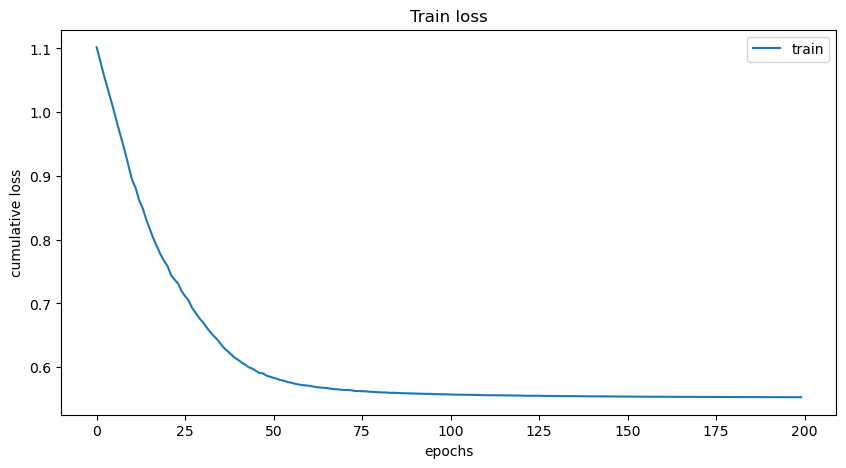

In [18]:
plt.figure(figsize=(10,5))
plt.title("Train loss")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

##### Test our model

Here we use the model to predict the label on unseen data, our test data.

The predictions are the predicted classes (in the encoded format 0-1-2) for each item in the test dataset.

In [19]:
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions

tensor([0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2,
        1, 2, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 0,
        0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 1, 0,
        1, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 2, 1, 2, 0])

##### Confusion Matrix

A confusion matrix is a really good way to visualise the number of true positives, false negatives, false positives, and true negatives.

The header row corresponds to the predicted labels while the first column corresponds to the ground truth.

In [20]:
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(
    cm, 
    index = encoder.classes_,
    columns = encoder.classes_
)
df_cm

,0,1,2
0,30,0,0
1,0,30,0
2,0,0,30


##### Visualising the confusion matrix with a seaborn heatmap

/var/folders/_8/j5x2xq991j5b0pw1xd50vpbh0000gn/T/ipykernel_18987/101969818.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


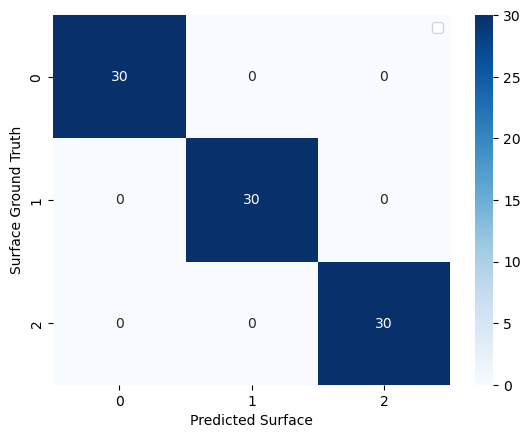

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)

##### Save model


In [22]:
PATH_SAVE = 'pose_classifier.pt'
torch.save(model.state_dict(), PATH_SAVE)

##### Load Inference Model

In [23]:
model_inference =  PoseClassificationMLP()
model_inference.load_state_dict(torch.load(PATH_SAVE, map_location=device))

<All keys matched successfully>

In [24]:
feature, label = test_dataset.__getitem__(12) # test out different item numbers

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground truth label : {encoder.classes_[label]}'
    )
print(encoder.classes_)

    prediction label : 2 
    ground truth label : 2
[0 1 2]


### Training tasks:

**Task A:** Run all the cells in this code to train your own pose classifier.

> There are some bonus tasks here if you want to further develop skills in training models. Feel free to come back to these after completing the tasks for building the interactive application.
> 
> **Bonus task A:** Use Sci-kit learn's [train-test split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split this dataset into a train and test/validation dataset. Every 10 epochs assess the perfomance of the model against the test set (like in [week-2b](Week-2b-build-and-train-dog-rating-network.ipynb)) and use early stopping to save and evaluate the most performant model.
> 
> **Bonus task B:** Test out the training with different hyper-parameters, or make modifications to the network architecture to try and improve classification accuracy on the test set.

### Interactive app tasks 

In [week-4d-pose-classification-dorothy-app.py](week-4d-pose-classification-dorothy-app.py) follow the tasks below to 

**Task 1:** Copy and paste [the model definition](#define-our-simple-feed-forward-network) from this notebook into [week-4d-pose-classification-dorothy-app.py](week-4d-pose-classification-dorothy-app.py). Then instantiate a copy of that class, load the weights of the model saved into `pose_classifier.pt` using [the torch load functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) and then put the model into eval mode.

**Task 2** Run your pose classifier model in inference in the draw loop (in the designated part of the code) on the variable `keypoint_data`. The use the `torch.max` function to get prediction for the pose of the user. 

**Task 3:** Use the predicted pose to alter the behaviour or trigger an action in the dorothy sketch. Each pose should have a different effect. For instance you could: 
- Draw text or geometric objects
- Manipulate animation of graphics on the screen
- Trigger the playback of audio
- Create a game where the user has to match a pose on command, there could be a time limit or points could be scored for how quickly the user responds to the instructed pose from the game.

If you did STEM for Creatives last term, can you adapt one of the sketches you created last term and use this pose classifer as a controller to interact with that sketch in some way?

For inspiration, checkout the [gallery of examples given in the dorothy-cci library](https://github.com/Louismac/dorothy/tree/main/examples).